In [182]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.api import OLS, add_constant
from linearmodels.asset_pricing import LinearFactorModel
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [183]:
import linearmodels
linearmodels.__version__

'4.26'

In [25]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]
ff_factor_data.info()
ff_factor_data.describe()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  96 non-null     float64
 1   SMB     96 non-null     float64
 2   HML     96 non-null     float64
 3   RMW     96 non-null     float64
 4   CMA     96 non-null     float64
 5   RF      96 non-null     float64
dtypes: float64(6)
memory usage: 5.2 KB


,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158438,0.059896,-0.049271,0.130000,0.047708,0.012604
std,3.580012,2.300378,2.202912,1.581971,1.413029,0.022583
min,-7.890000,-4.580000,-4.700000,-3.880000,-3.240000,0.000000
25%,-0.917500,-1.670000,-1.665000,-1.075000,-0.952500,0.000000
50%,1.235000,0.200000,-0.275000,0.210000,0.010000,0.000000
75%,3.197500,1.582500,1.205000,1.235000,0.930000,0.010000
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.090000


In [29]:
ff_pf = '17_Industry_Portfolios'
# no data after 2017-12 in the test file. it will be updated later
ff_pf_data = web.DataReader(ff_pf, 'famafrench', start='2010', end='2017-12')[0]
ff_pf_data = ff_pf_data.sub(ff_factor_data.RF, axis=0)
ff_pf_data.info()
ff_pf_data.describe()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 158 entries, 2010-01 to 2023-02
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    96 non-null     float64
 1   Mines   96 non-null     float64
 2   Oil     96 non-null     float64
 3   Clths   96 non-null     float64
 4   Durbl   96 non-null     float64
 5   Chems   96 non-null     float64
 6   Cnsum   96 non-null     float64
 7   Cnstr   96 non-null     float64
 8   Steel   96 non-null     float64
 9   FabPr   96 non-null     float64
 10  Machn   96 non-null     float64
 11  Cars    96 non-null     float64
 12  Trans   96 non-null     float64
 13  Utils   96 non-null     float64
 14  Rtail   96 non-null     float64
 15  Finan   96 non-null     float64
 16  Other   96 non-null     float64
dtypes: float64(17)
memory usage: 22.2 KB


,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.046771,0.202917,0.597187,1.395833,1.151458,1.305000,1.186979,1.735521,0.559167,1.350521,1.217708,1.279479,1.463750,0.896458,1.233958,1.248646,1.290937
std,2.800555,7.904401,5.480938,5.024408,5.163951,5.594161,3.142989,5.243314,7.389679,4.694408,4.798098,5.719351,4.143005,3.233107,3.512518,4.839150,3.697608
min,-5.170000,-24.380000,-11.680000,-10.000000,-13.160000,-17.390000,-7.150000,-14.160000,-20.490000,-11.960000,-9.070000,-11.650000,-8.560000,-6.990000,-9.180000,-11.140000,-7.890000
25%,-0.785000,-5.840000,-3.117500,-1.865000,-2.100000,-1.445000,-0.855000,-2.410000,-4.395000,-1.447500,-2.062500,-1.245000,-0.810000,-0.737500,-0.952500,-1.462500,-1.090000
50%,0.920000,-0.435000,0.985000,1.160000,1.225000,1.435000,1.465000,2.175000,0.660000,1.485000,1.525000,0.635000,1.480000,1.240000,0.865000,1.910000,1.660000
75%,3.187500,5.727500,4.152500,3.857500,4.160000,4.442500,3.302500,5.557500,4.212500,3.837500,4.580000,4.802500,4.242500,2.965000,3.370000,4.100000,3.485000
max,6.670000,21.940000,15.940000,17.190000,16.610000,18.370000,8.260000,15.510000,21.350000,17.660000,14.750000,20.860000,12.980000,7.840000,12.440000,13.410000,10.770000


In [43]:
with pd.HDFStore('data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [64]:
# filter: firms that have prices info only
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)
returns.tail(5)

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YRCW,YUM,ZAGG,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2017-08,8.245526,-11.117858,-4.343129,-3.550296,-12.597090,10.625073,12.457912,-1.357917,-14.073315,-3.820961,...,0.752445,1.775305,49.112426,-5.811078,1.346834,6.905658,-3.406683,15.551537,-0.375235,-1.968504
2017-09,-0.803461,6.146625,-1.383225,5.751534,1.392784,-6.024390,-1.497006,-3.396798,3.115265,9.080827,...,3.061987,-4.178599,25.000000,2.685355,5.325444,20.547945,8.062300,-3.912363,-7.909605,45.381526
2017-10,6.181355,-1.410823,-15.654366,1.522843,-17.600806,9.680768,-6.762918,8.398656,-7.009063,-0.104275,...,-2.391304,1.141149,-0.634921,3.868819,6.824461,-14.181818,-1.526070,-24.104235,-0.817996,-2.486188
2017-11,1.778627,7.838531,2.500000,4.142857,23.562515,1.662328,-5.867971,0.702479,10.758704,3.549061,...,-8.537491,12.115514,30.670927,-3.716494,-4.888352,5.508475,6.650882,-1.931330,-9.278351,23.512748
2017-12,-3.278452,3.050109,5.646872,0.685871,-1.297030,-1.524585,1.558442,1.600328,8.252771,-2.822581,...,16.720779,-2.228346,-9.779951,3.048676,-5.910080,7.881526,2.583249,-9.409190,-0.454545,-4.472477


In [72]:
# only take index(dates) have the returns info
ff_factor_data = ff_factor_data.loc[returns.index]
ff_pf_data = ff_pf_data.loc[returns.index]
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1.206000,0.056947,-0.054316,0.144737,0.043368,0.012737
std,3.568382,2.312400,2.214041,1.583725,1.419882,0.022665
min,-7.890000,-4.580000,-4.700000,-3.880000,-3.240000,0.000000
25%,-0.565000,-1.680000,-1.670000,-0.880000,-0.965000,0.000000
50%,1.290000,0.160000,-0.310000,0.270000,0.010000,0.000000
75%,3.265000,1.605000,1.220000,1.240000,0.940000,0.010000
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.090000


In [88]:
# excess returns = returns minus risk-free-rate
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
# remove outlier data from excess_returns
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1), upper=np.percentile(excess_returns, 99))

In [113]:
ff_factor_data.drop('RF', axis=1, inplace=True)
ff_factor_data.tail()

KeyError: "['RF'] not found in axis"

In [137]:
betas = []  # Factpr exposure
for industry in ff_pf_data:
    # OLS endog(endogenous:dependent variable) exog(exogenous:independent variable)
    # intercept term should be added by the user. Thus, add_constant function has been used.
    # if the data has the heteroskedasticity or autocorrelation on error term, using GLS than OLS
    step1 = OLS(endog=ff_pf_data.loc[ff_factor_data.index, industry],
                exog=add_constant(ff_factor_data)).fit()
    betas.append((step1.params.drop('const')))
    # print(f'Industry: {industry}\n{step1.params.drop("const")}\n')

betas = pd.DataFrame(betas, columns=ff_factor_data.columns, index=ff_pf_data.columns)
betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
Food,0.685206,-0.309058,-0.356319,0.307398,0.487738
Mines,1.308349,0.183393,0.222381,0.221504,0.537181
Oil,1.034263,0.170344,0.647723,0.003313,0.315890
Clths,0.966307,0.361005,-0.143524,0.620955,-0.031262
Durbl,1.178290,0.530581,0.067535,0.545414,-0.116301


In [141]:
lambdas = []
for period in ff_pf_data.index:
    steps2 = OLS(endog=ff_pf_data.loc[period, betas.index], exog=betas).fit()
    lambdas.append(steps2.params)

lambdas = pd.DataFrame(lambdas, index=ff_pf_data.index, columns=betas.columns.tolist())
lambdas.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-02,3.782825,5.172168,-0.973987,2.086636,-0.506548
2010-03,6.260254,-0.181305,-0.000494,2.643242,-1.527146
2010-04,1.824136,8.133189,-4.100088,-1.967232,-2.228364
2010-05,-7.726107,3.151571,-0.569618,1.322006,-0.041637
2010-06,-5.326121,-5.869757,-1.358489,-2.050018,0.084455


<Axes: >

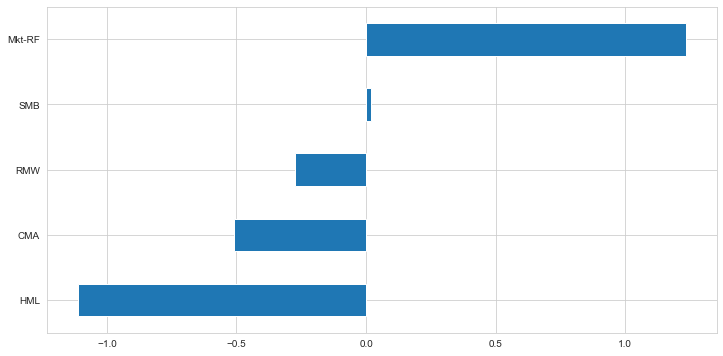

In [144]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 6))

In [175]:
t=lambdas.mean().div(lambdas.std())
lambdas.mean(), t

(Mkt-RF    1.235686
 SMB       0.020156
 HML      -1.113237
 RMW      -0.275555
 CMA      -0.509358
 dtype: float64,
 Mkt-RF    0.344320
 SMB       0.005152
 HML      -0.269338
 RMW      -0.090974
 CMA      -0.145308
 dtype: float64)

<Axes: xlabel='date'>

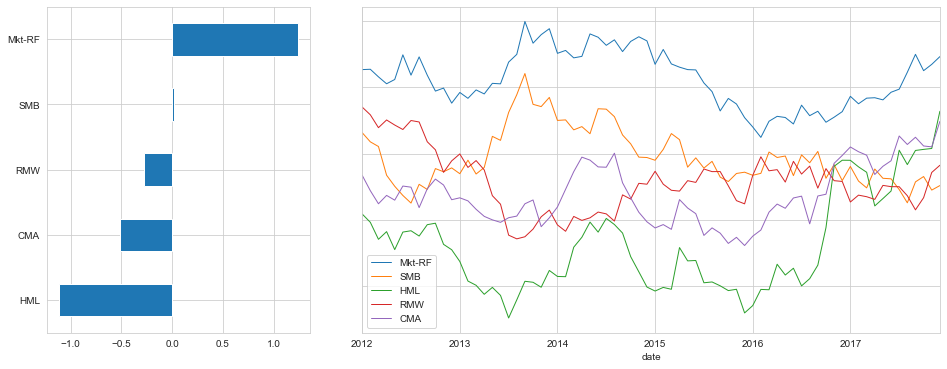

In [167]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1, figsize=(16, 6), sharey=True, ax=ax2)

In [174]:
# same results with the above 2 steps Fama-Macbeth methodology by LinearFactorModel below
mod = LinearFactorModel(portfolios=ff_pf_data, factors=ff_factor_data)
res = mod.fit()
res

LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 17   R-squared:                      0.6879
No. Factors:                          5   J-statistic:                    15.622
No. Observations:                    95   P-value                         0.2091
Date:                  Thu, Apr 06 2023   Distribution:                 chi2(12)
Time:                          23:02:55                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2357     0.4097     3.0158     0.0026      0.4326      2.0388
SMB            0.0202     0.8688     0.0232     0.9815     -1.6828      1.7231
HML           -1.1132     0.6218    -1.7905     0.0734     -2.3319      0.1054
RMW           -0.2756     0.8131    -0.3389     0.7347     -1.8693      1.3182
CMA           -0.5094     0.5661    -0.8998     0.3683     -1.6189      0.6002
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
LinearFactorModelResults, id: 0x1912af3c6a0

In [186]:
res.alphas

Food     0.175475
Mines   -0.697451
Oil      0.255741
Clths    0.241132
Durbl   -0.099930
Chems   -0.174017
Cnsum   -0.064672
Cnstr    0.578802
Steel   -0.388434
FabPr    0.170830
Machn   -0.297514
Cars    -0.143995
Trans    0.493473
Utils    0.353868
Rtail    0.018966
Finan    0.406127
Other   -0.155872
Name: alpha, dtype: float64

In [204]:
ff_factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2015', end='2023-04')[0]
ff_factor_data.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2022-10,7.83,1.86,8.05,3.07,6.52,0.23
2022-11,4.60,-2.67,1.38,6.01,3.11,0.29
2022-12,-6.41,-0.16,1.32,0.09,4.19,0.33
2023-01,6.65,4.43,-4.05,-2.62,-4.53,0.35
2023-02,-2.58,0.59,-0.80,0.92,-1.53,0.34


In [205]:
ff_pf = '17_Industry_Portfolios'
ff_pf_data = web.DataReader(ff_pf, 'famafrench', start='2015', end='2023-04')[0]
ff_pf_data = ff_pf_data.sub(ff_factor_data.RF, axis=0)
ff_pf_data.tail()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2022-10,10.06,8.21,23.87,10.41,3.62,9.08,8.28,6.99,19.94,12.04,8.85,-4.44,11.22,3.27,1.55,12.57,6.29
2022-11,3.89,16.90,0.47,16.61,6.70,9.73,4.96,8.58,13.61,6.04,11.07,-7.67,8.23,6.53,2.39,4.46,3.93
2022-12,-3.47,-4.63,-4.36,-0.70,-5.30,-6.75,-1.11,-3.79,-7.96,-6.01,-6.91,-25.68,-4.22,-1.48,-9.78,-5.82,-6.73
2023-01,-2.21,14.55,2.43,9.14,12.85,10.81,-3.00,6.78,21.82,12.50,9.07,23.31,5.38,-1.61,11.79,6.11,7.78
2023-02,-1.75,-5.56,-7.34,-6.58,-2.12,-4.99,-5.14,-4.01,1.78,2.69,0.46,10.02,-0.92,-5.63,-6.04,-2.81,-2.19
